In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
x_df=pd.read_csv("/content/drive/MyDrive/CyberLabs ML/nn_train.csv", header=0)


#Dividing dataset into two halves of 70:30 sizes
x_tr=x_df.iloc[0:56000,1:1025].values
y_tr_1=x_df.iloc[0:56000,1025:1026].values
y_tr_2=x_df.iloc[0:56000,1026:1027].values

x_tst=x_df.iloc[56000:80001,1:1025].values
y_tst_1=x_df.iloc[56000:80001,1025:1026].values
y_tst_2=x_df.iloc[56000:80001,1026:1027].values



In [50]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column

    Args:
      X (ndarray (m,n))     : input data, m examples, n features

    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma

    return (X_norm, mu, sigma)

x_tr_n, x_mu1, x_sig1 = zscore_normalize_features(x_tr)

x_tst_n, x_mu3, x_sig3 = zscore_normalize_features(x_tst)


In [51]:
# Hyperparameters
input_size = 1024
hidden_size_1 = 32
hidden_size_2 = 16
output_size = 1
learning_rate = 0.01
num_iterations = 1000
batch_size = 128

In [52]:
def initialize_parameters():
    np.random.seed(42)  # For reproducibility
    W1 = np.random.randn(input_size, hidden_size_1) * 0.01
    b1 = np.zeros((1, hidden_size_1))
    W2 = np.random.randn(hidden_size_1, hidden_size_2) * 0.01
    b2 = np.zeros((1, hidden_size_2))
    W3 = np.random.randn(hidden_size_2, output_size) * 0.01
    b3 = np.zeros((1, output_size))
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    return parameters

In [53]:
# ReLU activation function
def relu(Z):
    return np.maximum(0, Z)

# Sigmoid activation function
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [54]:
# Forward propagation
def forward_propagation(X, parameters):
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]

    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = relu(Z2)
    Z3 = np.dot(A2, W3) + b3
    A3 = sigmoid(Z3)  # Output layer uses sigmoid activation

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    return A3, cache

In [55]:
# Compute the cost function
def compute_cost(A3, Y):
    m = Y.shape[0]
    cost = -np.sum(Y * np.log(A3) + (1 - Y) * np.log(1 - A3)) / m
    return cost

In [56]:
# Backward propagation
def backward_propagation(X, Y, parameters, cache):
    m = X.shape[0]
    W1, W2, W3 = parameters["W1"], parameters["W2"], parameters["W3"]
    A1, A2, A3 = cache["A1"], cache["A2"], cache["A3"]

    # Output layer
    dZ3 = A3 - Y
    dW3 = np.dot(A2.T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    # Hidden layer 2
    dZ2 = np.dot(dZ3, W3.T) * (A2 > 0)  # Derivative of ReLU is 1 for positive inputs
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Hidden layer 1
    dZ1 = np.dot(dZ2, W2.T) * (A1 > 0)  # Derivative of ReLU is 1 for positive inputs
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}
    return grads

In [57]:
# Update parameters
def update_parameters(parameters, grads, learning_rate):
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]

    W1 -= learning_rate * grads["dW1"]
    b1 -= learning_rate * grads["db1"]
    W2 -= learning_rate * grads["dW2"]
    b2 -= learning_rate * grads["db2"]
    W3 -= learning_rate * grads["dW3"]
    b3 -= learning_rate * grads["db3"]

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    return parameters

In [58]:
# Train the model
def train_model(X, Y, num_iterations, batch_size, learning_rate):
    m = X.shape[0]
    parameters = initialize_parameters()
    costs = []

    for i in range(num_iterations):
        # Mini-batch gradient descent
        for j in range(0, m, batch_size):
            X_batch = X[j:j+batch_size]
            Y_batch = Y[j:j+batch_size]

            # Forward and backward propagation
            A3, cache = forward_propagation(X_batch, parameters)
            cost = compute_cost(A3, Y_batch)
            grads = backward_propagation(X_batch, Y_batch, parameters, cache)

            # Update parameters
            parameters = update_parameters(parameters, grads, learning_rate)

        # Record cost every 100 iterations
        if i % 100 == 0:
            costs.append(cost)
            print(f"Iteration {i}: cost = {cost:.4f}")

    return parameters, costs

In [59]:
def predict(X, parameters):
    A3, _ = forward_propagation(X, parameters)
    predictions = (A3 > 0.5).astype(int)  # Output is binary (0 or 1)
    return predictions

In [62]:
# Train the model
parameters, costs = train_model(x_tr_n, y_tr_1, num_iterations=150, batch_size=128, learning_rate=0.01)

Iteration 0: cost = 0.6930
Iteration 100: cost = 0.1477


<ipython-input-55-264a5a14b023>:4: RuntimeWarning: divide by zero encountered in log
  cost = -np.sum(Y * np.log(A3) + (1 - Y) * np.log(1 - A3)) / m
<ipython-input-55-264a5a14b023>:4: RuntimeWarning: invalid value encountered in multiply
  cost = -np.sum(Y * np.log(A3) + (1 - Y) * np.log(1 - A3)) / m


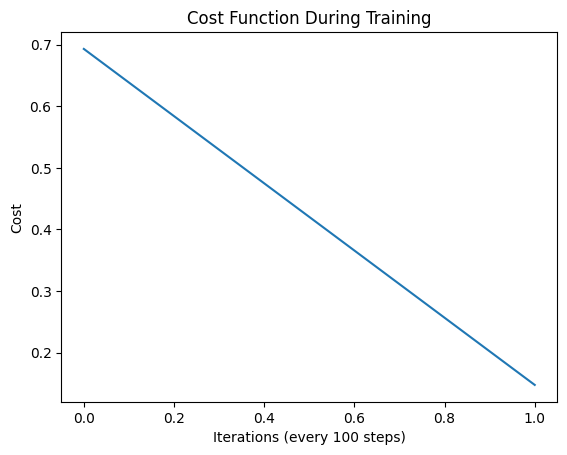

In [65]:
# Plot the cost function
plt.plot(np.arange(2), costs)
plt.xlabel('Iterations (every 100 steps)')
plt.ylabel('Cost')
plt.title('Cost Function During Training')
plt.show()

In [66]:
predictions = predict(x_tst_n, parameters)

# Evaluate performance
accuracy = np.mean(predictions == y_tst_1) * 100
print(f"Testing Accuracy: {accuracy:.2f}%")

Testing Accuracy: 75.60%


In [67]:
# Calculate True Positives (TP), False Positives (FP), False Negatives (FN), and True Negatives (TN)
TP = np.sum((y_tst_1 == 1) & (predictions == 1))  # True Positives
FP = np.sum((y_tst_1 == 0) & (predictions == 1))  # False Positives
FN = np.sum((y_tst_1 == 1) & (predictions == 0))  # False Negatives
TN = np.sum((y_tst_1 == 0) & (predictions == 0))  # True Negatives

# Calculate Precision and Recall
precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # To avoid division by zero
recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # To avoid division by zero

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 0.7488
Recall: 0.7657
F1 Score: 0.7572


In [69]:
test_df=pd.read_csv("/content/drive/MyDrive/CyberLabs ML/nn_train.csv", header=0)
test_arr=test_df.iloc[:,1:1025].values

predictions2 = predict(x_tst_n, parameters)
pred_df=pd.DataFrame(predictions2)



In [70]:
pred_df.to_csv("NN_Bin_test.csv", index= False)

In [71]:
! ls

drive  NN_Bin_test.csv	sample_data


In [72]:
! cat "NN_Bin_test.csv"

0
0
0
0
1
0
1
0
0
0
1
0
0
0
1
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
1
1
1
0
1
1
0
0
1
0
0
0
0
1
1
1
1
1
0
0
1
1
1
0
0
1
0
1
1
1
1
1
1
0
1
0
1
1
0
1
1
1
0
0
1
0
1
0
0
1
0
1
1
0
1
1
0
1
0
1
1
1
1
0
1
1
0
0
0
1
0
1
1
0
0
0
0
1
0
0
0
0
0
1
0
1
1
0
0
0
1
0
1
1
0
0
0
1
0
1
0
1
0
0
1
1
1
1
1
1
1
0
1
0
0
0
0
0
0
1
1
0
0
1
1
1
1
1
1
0
1
1
0
0
1
0
1
0
0
0
1
0
1
1
0
0
0
1
1
0
0
0
0
1
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
1
1
1
1
0
1
1
0
1
1
1
1
1
0
1
0
1
0
0
1
1
0
1
0
0
0
1
1
0
0
0
1
0
1
0
1
1
1
1
1
1
1
0
0
1
1
1
0
0
0
1
0
1
0
1
0
1
1
1
0
0
1
1
0
1
1
1
1
0
0
1
1
0
0
1
1
1
1
0
1
1
0
1
1
1
1
1
1
0
0
1
0
1
0
0
0
0
1
1
1
0
0
1
0
0
1
1
1
1
1
0
1
0
1
1
1
0
0
1
1
0
1
0
0
0
0
0
0
1
0
1
1
1
1
0
0
1
0
1
1
0
1
1
0
0
0
1
1
1
0
1
1
1
0
1
0
0
1
1
1
0
1
1
0
1
1
0
1
0
1
1
1
1
1
0
0
0
1
1
0
0
0
0
0
1
1
1
0
0
1
0
0
1
0
0
1
1
1
0
1
0
0
0
0
0
1
0
0
0
1
0
1
0
0
1
1
0
1
0
0
1
0
0
1
0
0
0
0
0
0
1
1
0
1
0
1
1
1
1
0
1
1
1
0
1
1
1
0
1
1
0
0
0
0
1
0
0
0
0
1
1
1
1
0
0
1
1
0
1
0
1
1
0
0
0
0
1
1
1
0
1
0
1
1
1
0
1
0
1
1
0
0
1
1
